In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from sklearn.preprocessing import quantile_transform

In [82]:
from matplotlib import cm

In [5]:
balances_df = pd.read_csv("./data/ethereum_genesis_snapshot.csv")

In [6]:
balances_df = balances_df.sort_values("balance", ascending=False)

In [7]:
TOTAL_CYB = 11116463155970720 * 0.1 # ethereum drop amount
TOTAL_THRESHOLD = 0.8

In [8]:
MIN_CYB = 1000

In [9]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T', 'Q'][magnitude])

In [76]:
def get_description(group_name, balances_df, title=False):
    template = "{} \n{} addresses \n{} CYB total \n{} CYB average \n{} CYB min"
    if title:
        template = "{} - {} addresses \n{} CYB total, {} CYB average, {} CYB min"
    return template.format(
        group_name, 
        human_format(balances_df[balances_df["cyb_balance"] >= MIN_CYB].shape[0]),
        human_format(balances_df["cyb_balance"].sum()), 
        human_format(balances_df["cyb_balance"].mean()),
        human_format(balances_df["cyb_balance"].min())
    )

In [77]:
def get_names(quantiles):
    return ["TOP-{}".format(human_format(q)) for q in quantiles]

In [103]:
def generate_piechart(balances_df, balance_field, total_threshold=TOTAL_THRESHOLD):
    balances_df["percentage"] = (balances_df[balance_field] / balances_df[balance_field].sum())
    balances_df["threshold"] = balances_df["percentage"].cumsum()
    balances_df = balances_df[balances_df["threshold"] <= total_threshold].copy()
    
    balances_df["percentage"] = (balances_df[balance_field] / balances_df[balance_field].sum())
    balances_df["cyb_balance"] = balances_df["percentage"] * TOTAL_CYB
    
    top_levels = np.array([1000, 10000, 100000, 500000, 1000000, 5000000, 100000000, 500000000]) / balances_df.shape[0]
    top_levels = np.array([level for level in top_levels if level < 1])

    quantiles = balances_df["threshold"].quantile(q=top_levels).to_frame()
    quantiles["name"] = get_names(top_levels * balances_df.shape[0])

    balances_df["level"] = ""
    for _, row in quantiles.sort_values("threshold", ascending=False).iterrows():
        selected_indices = balances_df["threshold"] < row["threshold"]
        balances_df.loc[selected_indices, "level"] = row["name"]
        description = get_description(row["name"], balances_df[selected_indices])
        balances_df.loc[selected_indices, "level_description"] = description
    
    unknown_indices = balances_df["level"] == ""
    balances_df.loc[unknown_indices, "level"] = "Other"
    balances_df.loc[unknown_indices, "level_description"] = get_description("Other", balances_df[balances_df["level"] == "Other"])

    balances_size = balances_df.groupby("level_description")["cyb_balance"].mean().sort_values()
#     balances_size.plot(kind="pie", figsize=(10, 10), fontsize=10, colormap='Reds')
    balances_size.plot(kind="barh", figsize=(15, 10), fontsize=10, color='blue')
    
#     legend = [ for name in balances_size.index]
#     plt.legend(legend)
    
    plt.title(get_description("Total", balances_df, title=True), fontsize=20)
    plt.ylabel("Group", fontsize=20)
    plt.xlabel("Average balance", fontsize=20)

# Вариант A (Без изменений)

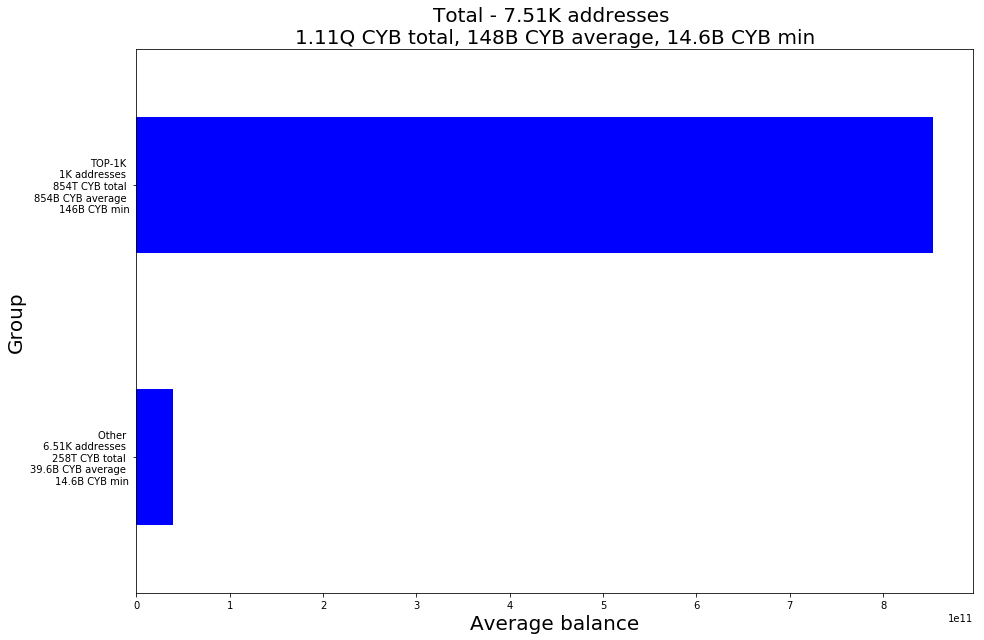

In [104]:
generate_piechart(balances_df, "balance")

# Вариант B (Квадратный корень)

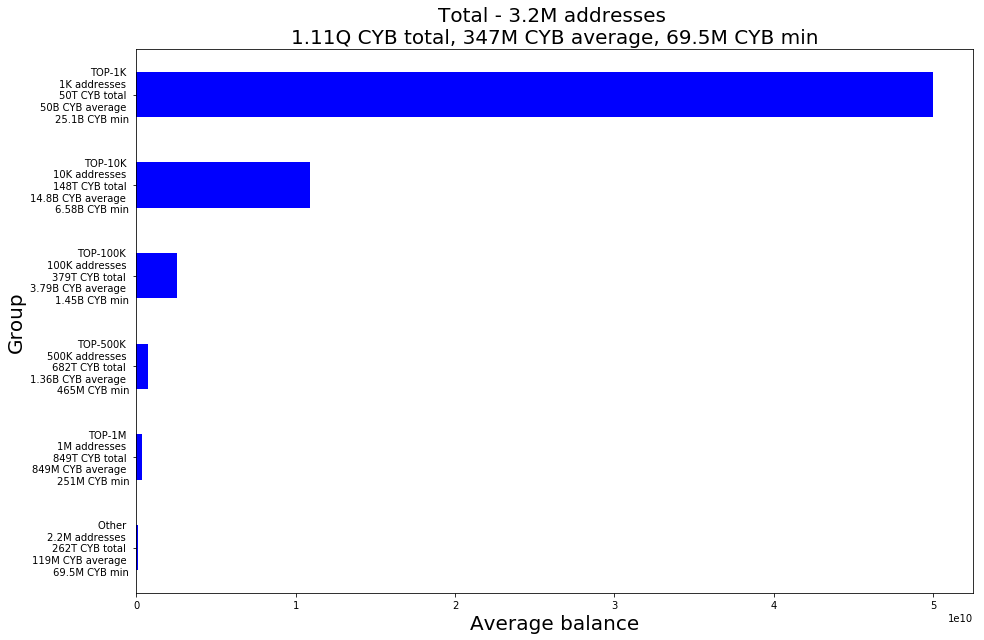

In [105]:
balances_df["sqrt_balance"] = balances_df["balance"].pow(0.5)
generate_piechart(balances_df, "sqrt_balance")

# Вариант C (Логарифм)

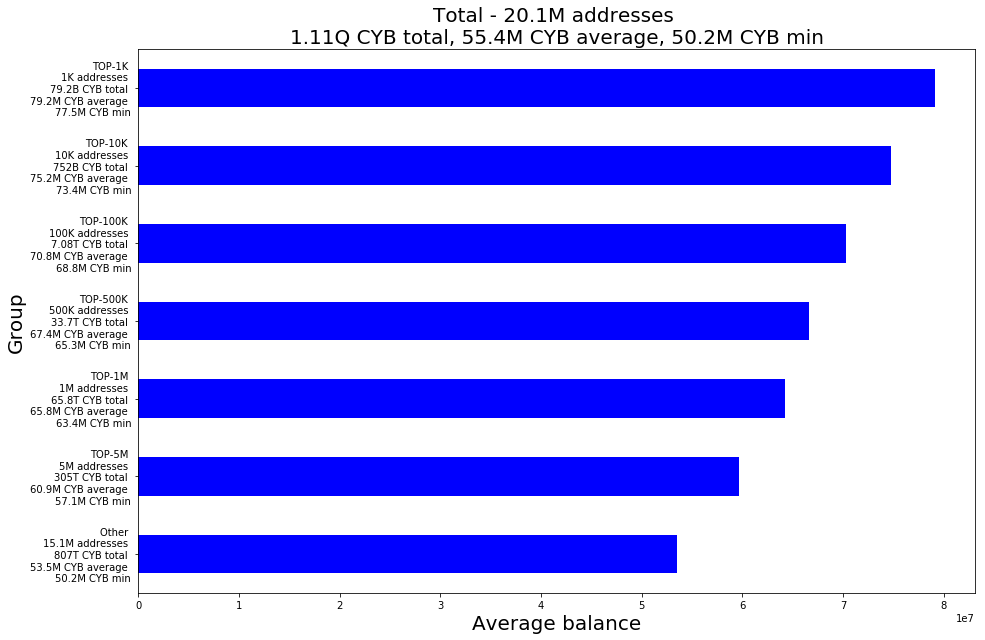

In [106]:
balances_df["log_balance"] = np.log(balances_df["balance"]) - np.log(balances_df["balance"]).min()
generate_piechart(balances_df, "log_balance")

# Вариант D (Квантильное преобразование)

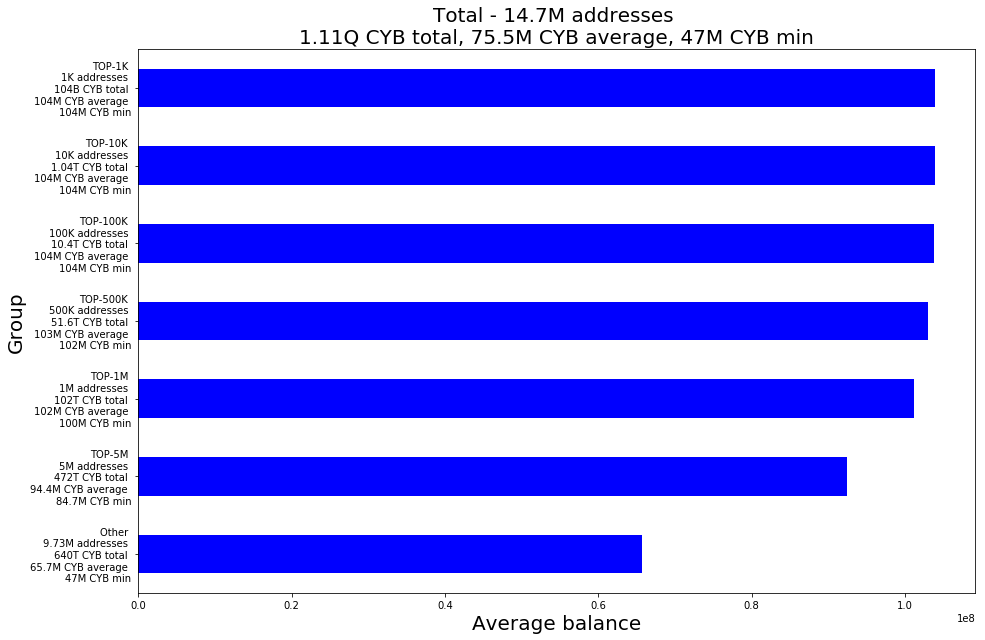

In [107]:
balances_df["qt_balance"] = quantile_transform(balances_df["balance"].values.reshape(-1, 1), copy=True).reshape(-1)
generate_piechart(balances_df, "qt_balance")

# Вывод:
Выбор способа распределения может зависеть от:
- Необходимого количества участников с существенным балансом
- Ожидаемой разницы между китами и пескарями

Использование квадратного корня в варианте B позволяет существенно увеличить список адресов с 7.5к (крупные владельцы эфира, суммарный баланс > 80% от общего количества) до 3М за счет уменьшения разрыва между китами и пескарями. 

Если планируется провести распределение среди большего количества участников, то рекомендуется вариант C.
- В распределении участвует большое количество адресов (20М)
- Есть разница между балансом китов и пескарей, но она не так существенна, как в B
- При этом баланс каждой группы является существенным - хотя бы 50М CYB